### Multi-omic Dataset: Latent representation using KPCA
- Load Data
- Normalize Data
- Perform KPCA on Data
- Plot First 2 Principal Components
- Use transformed dataset for classification
- Use transformed dataset for clustering
- Evaluation and Conclusions

In [1]:
import numpy as np
import random as rn
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

rn.seed(1)
np.random.seed(1)
tf.random.set_seed(1)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# Load Data
X_renal_data = pd.read_csv('./x_exp_renal.csv', sep='\t') # Dataset has Donor ID as first column
y_renal_data = pd.read_csv('./y_renal.csv', sep=',') # Dataset has Donor ID on first column and Label on second column.

from sklearn.model_selection import train_test_split
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_renal_data.iloc[:,1:],y_renal_data["label"],test_size=0.2, random_state=1) # Drop the Donor ID column from both datasets
# Normalization of data sets
# Data Scaling MinMax
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_norm = X_train
X_test_norm = X_test

X_train_norm = pd.DataFrame(scaler.fit_transform(X_train_norm))
X_test_norm = pd.DataFrame(scaler.transform(X_test_norm))

# We will use "X_train_norm" as training dataset for KPCA

In [47]:
## Feature selection
from sklearn.feature_selection import VarianceThreshold

X_train_select = X_train_norm
selector = VarianceThreshold(0.025)
X_train_select = selector.fit_transform(X_train_select)
X_test_select = selector.transform(X_test_norm)
print(X_train_select.shape)

(433, 4771)


(433, 5126)


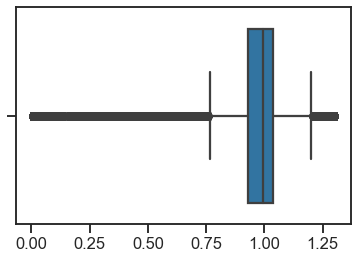

In [15]:
X_std = np.std(X_train)
ax = sns.boxplot(x=X_std)
X_threshold = np.percentile(X_std, 75)
X_select = X_std > X_threshold
X_train_select = X_train.loc[:,X_select]
X_test_select = X_test.loc[:,X_select]
print(X_train.loc[:,X_select].shape)

In [17]:
scaler = MinMaxScaler()
X_train_norm = X_train_select
X_test_norm = X_test_select

X_train_norm = pd.DataFrame(scaler.fit_transform(X_train_norm))
X_test_norm = pd.DataFrame(scaler.transform(X_test_norm))

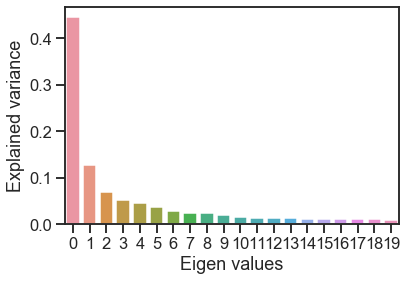

0.7771646817197064


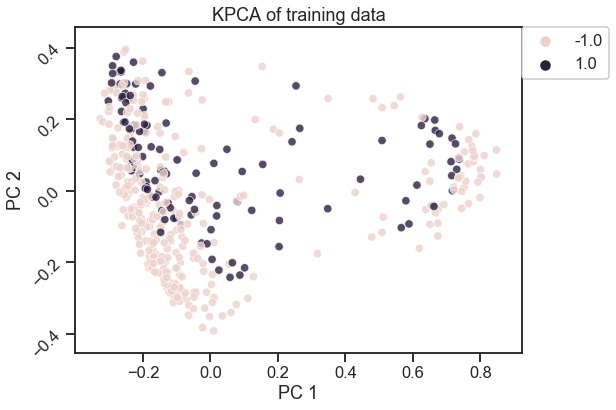

In [21]:
## Perform KPCA
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=20, kernel="rbf", gamma=0.007)
X_kpca = kpca.fit_transform(X_train_norm)
X_test_kpca = kpca.transform(X_test_norm)

X_kpca_var = np.var(X_kpca,0)
X_kpca_var_ratio = X_kpca_var / sum(X_kpca_var)

X_kpca_train_labeled = np.c_[X_kpca , y_train]

sns.barplot(np.arange(np.shape(X_kpca_var_ratio)[0]),X_kpca_var_ratio)
plt.xlabel("Eigen values")
plt.ylabel("Explained variance")
plt.show()

print(X_kpca_var_ratio[:6].sum())

sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
ax1 = plt.subplot()
sns.scatterplot(x=X_kpca[:,0], 
                y=X_kpca[:,1], 
                alpha = 0.8, 
                s= 70, legend='full', 
                hue=X_kpca_train_labeled[:,-1])
ax1.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,framealpha=1, frameon=True)
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.figure.set_size_inches( (8,6) )
ax1.set_title("KPCA of training data")
plt.yticks(rotation=45) 
plt.show()

## We will use the datasets "X_kpca" and "X_train_norm"


(433, 20)

In [23]:
### CLASSIFICATION ###
# We use the reduced dataset to train a classifier and compare it against the same classifier trained with the original dataset.

# One hot encode labels
from sklearn.preprocessing import LabelEncoder
OH_encoder = LabelEncoder()
OH_y_train = pd.DataFrame(OH_encoder.fit_transform(y_train))
OH_y_test = pd.DataFrame(OH_encoder.transform(y_test))
y_train_oh = keras.utils.to_categorical(OH_y_train)
y_test_oh = keras.utils.to_categorical(OH_y_test)

## Definition of the best classifier obtained previously (CTG_dataset_classification)
def build_best_model(dropout: int, l1: int, l2: int, input_shape: int):
    model = keras.Sequential([
        layers.Dense(1000, activation=tf.nn.relu ,kernel_regularizer=keras.regularizers.l1_l2(l1,l2), input_shape=[len(X_train_norm.keys())]),
        layers.Dropout(dropout),
        layers.BatchNormalization(),  
        layers.Dense(20,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l1_l2(l1,l2)),
        layers.Dropout(dropout),
        layers.BatchNormalization(),
        layers.Dense(2,activation=tf.nn.softmax)
      ])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
    return model

# Set Early Stop Callback
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10,  mode='auto', baseline=None, restore_best_weights=False, verbose=1)

# Fit best model with dimensionality reduction data
model_kpca = build_best_model(0.5,0.0001, 0.0001, X_kpca.shape[1])
history_kpca = model_kpca.fit(X_kpca, y_train_oh, epochs=200,
                    validation_split = 0.1, verbose=1, callbacks=[early_stop], shuffle=False)
hist_kpca = pd.DataFrame(history_kpca.history)

test_loss, test_acc = model_ae.evaluate(X_test_kpca, y_test_oh)


ValueError: Error when checking input: expected dense_3_input to have shape (5126,) but got array with shape (20,)

KPCA silhoutte score: 0.26299890812406757
Original silhoutte score: 0.44586266793653406


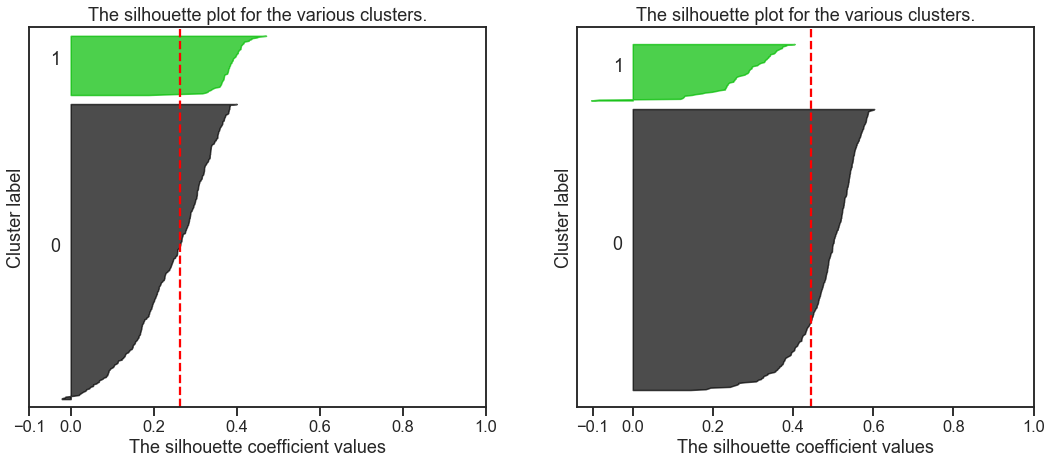

In [62]:
###### CLUSTERING ###
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.cm as cm
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kpca_cluster_labels = kmeans.fit_predict(X_kpca)
kpca_silhouette_avg = silhouette_score(X_kpca, kpca_cluster_labels)

cluster_labels = kmeans.fit_predict(X_train_norm)
silhouette_avg = silhouette_score(X_train_norm, cluster_labels)

print(f"KPCA silhoutte score: {kpca_silhouette_avg}")
print(f"Original silhoutte score: {silhouette_avg}")

### PLOT SILOHUETTE SCORE FOR CLUSTERS
# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X_kpca) + (n_clusters + 1) * 10])

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_kpca, kpca_cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=kpca_silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_train_norm, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax2.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax2.set_title("The silhouette plot for the various clusters.")
ax2.set_xlabel("The silhouette coefficient values")
ax2.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax2.axvline(x=silhouette_avg, color="red", linestyle="--")

ax2.set_yticks([])  # Clear the yaxis labels / ticks
ax2.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

### Conclusion
Here we compare the performance of classification and clustering models using the original renal cancer genetic expression dataset and the same dataset with dimensionality reduction, using  KPCA method. 
To perform KPCA, we need to reduce the number of features of the dataset, because it is not possible to do it with the original 20500+ features. To reduce it, we droped the features with lower variance, keeping about 5000 features that let us compute KPCA using sklearn library. 
The model used to classify, was obtained experimentally, trying different hyperparamenters, and it is the best that could be obtained given the high dimensionality of the dataset, within feasible training times. Thus, this model is relatively small and shallow. 